In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
import json

DATASET = "2dcubes_grayscale_shapes_imbalanced_scale_1.0_equi_child_noise_allow_collisions_10k_transparent"
# DATASET = "2dcubes"

DATA_DIR = Path("outputs/images")
DATASET_DIR = DATA_DIR / DATASET

OUT_DIR = Path("outputs/compressed") / DATASET

OUT_DIR.mkdir(parents=True, exist_ok=True)

SHUFFLE = True

In [2]:
CAUSAL_VARIABLES = [
    "pos_x1",
    "pos_y1",
    "pos_x2",
    "pos_y2",
    "pos_x3",
    "pos_y3",
]
# NOTE: Index in this list determines value of intervention label
INTERVENTIONS = ["_empty_intervention"] + CAUSAL_VARIABLES

In [3]:
tags = [tag.name for tag in sorted(DATASET_DIR.iterdir()) if tag.is_dir()]
tags

['dci_train', 'test', 'train', 'val']

In [4]:
def extract_images(dir):
    _imgs = []
    for file in sorted((dir / "data").iterdir(), key=lambda x: int(x.stem)):
        if file.suffix != ".png":
            continue
        with Image.open(file) as img:
            _imgs.append(np.array(img))
    return _imgs

In [5]:
def extract_label(dir, intervention_label):
    _original_latents = []
    _intervention_labels = []
    _intervention_masks = []
    _epsilon = []
    for file in sorted((dir / "labels").iterdir(), key=lambda x: int(x.stem)):
        if file.suffix != ".json":
            continue
        with open(file) as f:
            label = json.load(f)
            scm_outcomes = label["scm_outcomes"]
            scm_noise_values = label["scm_noise_values"]

            _original_latents.append(
                [scm_outcomes[causal_variable] for causal_variable in CAUSAL_VARIABLES]
            )
            _epsilon.append(
                [scm_noise_values[causal_variable] for causal_variable in CAUSAL_VARIABLES]
            )
            _intervention_labels.append(intervention_label)
            _intervention_masks.append(
                [
                    True if intervention_label == i else False
                    for i in range(1, len(CAUSAL_VARIABLES) + 1)
                ]
            )

    return (
        np.array(_original_latents, dtype=np.float32),
        np.array(_intervention_labels, dtype=np.uint8),
        np.array(_intervention_masks, dtype=bool),
        np.array(_epsilon, dtype=np.float32),
    )

In [6]:
for tag in tags:
    imgs_original = []
    imgs_intervention = []

    original_latents_original = []
    original_latents_intervention = []

    epsilon_original = []
    epsilon_intervention = []

    intervention_labels = []
    intervention_masks = []

    DATASET_TAG_DIR = DATASET_DIR / tag

    batches = sorted([batch.name for batch in DATASET_TAG_DIR.iterdir() if batch.is_dir()], key=int)
    for batch in batches:
        print(
            f"\r({tag}) Processing batch {batch}/{batches[-1]}",
            end="" if batch != batches[-1] else "\n",
        )
        DATASET_BATCH_DIR = DATASET_TAG_DIR / batch

        intervention_dirs = [
            intervention_label.name
            for intervention_label in sorted(DATASET_BATCH_DIR.iterdir())
            if (intervention_label.is_dir())
        ]

        if sorted(intervention_dirs) != sorted(INTERVENTIONS):
            raise ValueError(
                f"Intervention labels {intervention_dirs} do not match causal variables {INTERVENTIONS}"
            )

        for intervention in intervention_dirs:
            # print(f"({tag}) Processing {intervention}")

            if INTERVENTIONS.index(intervention) is None:
                print(intervention)
                raise ValueError(f"Intervention {intervention} not in {INTERVENTIONS}")

            DATASET_INTERVENTION_DIR = DATASET_BATCH_DIR / intervention
            for set in ["original", "counterfactual"]:
                DATASET_SET_DIR = DATASET_INTERVENTION_DIR / set
                _imgs = extract_images(DATASET_SET_DIR)
                (
                    _original_latents,
                    _intervention_labels,
                    _intervention_mask,
                    _epsilon,
                ) = extract_label(
                    DATASET_SET_DIR, intervention_label=INTERVENTIONS.index(intervention)
                )
                if set == "original":
                    imgs_original.extend(_imgs)
                    original_latents_original.extend(_original_latents)
                    epsilon_original.extend(_epsilon)
                elif set == "counterfactual":
                    imgs_intervention.extend(_imgs)
                    original_latents_intervention.extend(_original_latents)
                    epsilon_intervention.extend(_epsilon)

                    intervention_labels.extend(_intervention_labels)
                    intervention_masks.extend(_intervention_mask)

    imgs = np.stack([imgs_original, imgs_intervention], axis=1, dtype=np.uint8)
    original_latents = np.stack(
        [original_latents_original, original_latents_intervention], axis=1, dtype=np.float32
    )
    intervention_labels = np.array(intervention_labels, dtype=np.uint8)
    intervention_masks = np.array(intervention_masks, dtype=bool)
    epsilon = np.stack([epsilon_original, epsilon_intervention], axis=1, dtype=np.float32).squeeze()

    if SHUFFLE == True:
        p = np.random.permutation(len(intervention_labels))
        imgs = imgs[p]
        original_latents = original_latents[p]
        intervention_labels = intervention_labels[p]
        intervention_masks = intervention_masks[p]
        epsilon = epsilon[p]
    print(f"({tag}) Saving...")
    np.savez_compressed(
        OUT_DIR / f"{tag}.npz",
        imgs=imgs,
        original_latents=original_latents,
        intervention_labels=intervention_labels,
        intervention_masks=intervention_masks,
        epsilon=epsilon,
    )

(dci_train) Processing batch 4/4
(dci_train) Saving...
(test) Processing batch 4/4
(test) Saving...
(train) Processing batch 34/34
(train) Saving...
(val) Processing batch 4/4
(val) Saving...


## Statistics

In [45]:
data_parts = []

filename = OUT_DIR / f"train.npz"
data_parts.append(dict(np.load(filename)))
data = {k: np.concatenate([data[k] for data in data_parts]) for k in data_parts[0]}

In [46]:
# iterate over data
for k, v in data.items():
    print(k, v.shape, v.dtype)

imgs (10000, 2, 128, 128, 3) uint8
original_latents (10000, 2, 6) float32
intervention_labels (10000,) uint8
intervention_masks (10000, 6) bool
epsilon (10000, 2, 6) float32


In [47]:
data["imgs"][0, 0].shape

(128, 128, 3)

In [48]:
np.unique(data["intervention_labels"])

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [49]:
label_distribution = np.bincount(data["intervention_labels"])
label_distribution

array([1445, 1485, 1396, 1396, 1337, 1422, 1519])

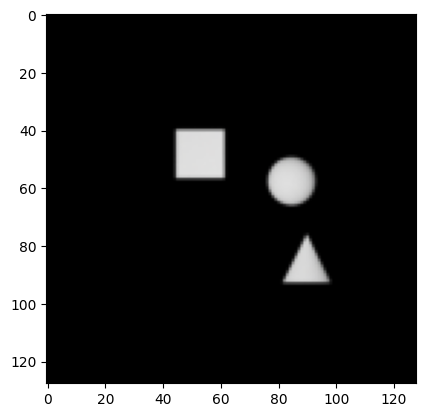

In [50]:
import matplotlib.pyplot as plt

plt.imshow(data["imgs"][2000, 1])

In [51]:
d = np.hstack([data["imgs"][:, 0], data["imgs"][:, 1]])

In [52]:
d_mean, d_std = d.mean(axis=(0, 1, 2)), d.std(axis=(0, 1, 2))
d_mean, d_std

(array([7.57570794, 7.57323261, 7.57117031]),
 array([38.25864702, 38.25024621, 38.23980411]))

In [53]:
d_min, d_max = d.min(axis=(0, 1, 2)), d.max(axis=(0, 1, 2))
d_min, d_max

(array([0, 0, 0], dtype=uint8), array([227, 227, 227], dtype=uint8))